In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error



## DRILL: Improve this gradient boost model
While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# create new varibles from weaker ones
X['sclact_pplfair'] = X['sclact'] * X['pplfair']
X['gndr_pplhlp'] = X['gndr'] * X['pplhlp']
X['sclmeet_sqr'] = X['sclmeet'] ** 2
X['happy_cube'] = X['happy'] ** 2
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
X.head()


,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE,sclact_pplfair,gndr_pplhlp,sclmeet_sqr,happy_cube
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1,0,0,0,0,0,40.0,10.0,25.0,64.0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1,0,0,0,0,0,14.0,10.0,9.0,81.0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1,0,0,0,0,0,24.0,8.0,36.0,49.0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1,0,0,0,0,0,12.0,14.0,36.0,100.0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1,0,0,0,0,0,14.0,10.0,49.0,64.0


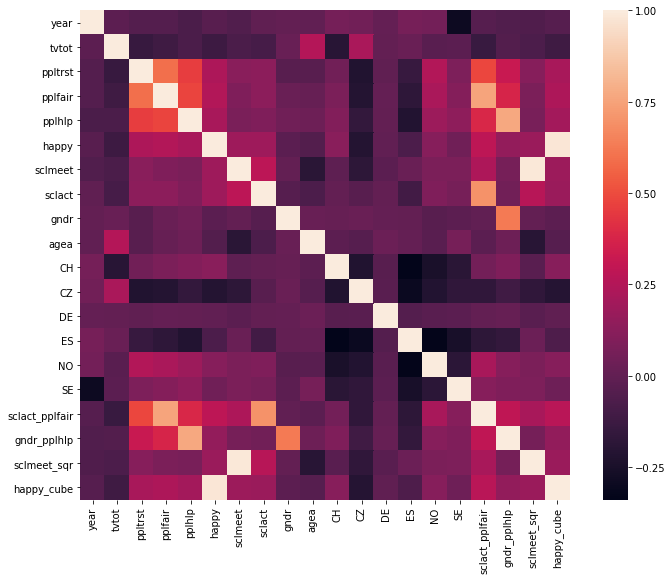

In [4]:
import seaborn as sns
# Inspect correlations
corrmat = X_train.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1, square=True)
plt.show()

In [21]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
# exponential, deviance
params = {'n_estimators': 660,
          'max_depth': 5,
          'subsample': 0.75, 
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0035460992907801418
Percent Type II errors: 0.03000545553737043

Test set accuracy:
Percent Type I errors: 0.09325153374233129
Percent Type II errors: 0.1754601226993865


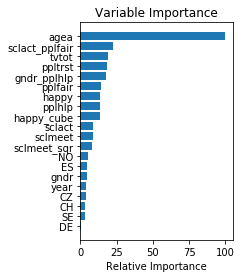

In [6]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()